Week 7 · Day 4 — Regularization for CNNs
Why this matters

CNNs with many parameters can easily overfit: training accuracy goes up, but validation accuracy stalls or drops. Regularization methods (dropout, weight decay, early stopping) keep models from memorizing training data and improve generalization.

Theory Essentials

Overfitting: model memorizes training data → poor generalization.

Dropout: randomly zeroes activations to force redundancy.

Weight decay (L2 penalty): discourages overly large weights.

Early stopping: stop training when validation stops improving.

Tradeoff: too much regularization can underfit.

Epoch 1: train 0.604 | val 0.374 | acc 0.860
Epoch 2: train 0.372 | val 0.312 | acc 0.884
Epoch 3: train 0.320 | val 0.282 | acc 0.895
Epoch 4: train 0.294 | val 0.267 | acc 0.904
Epoch 5: train 0.271 | val 0.245 | acc 0.906


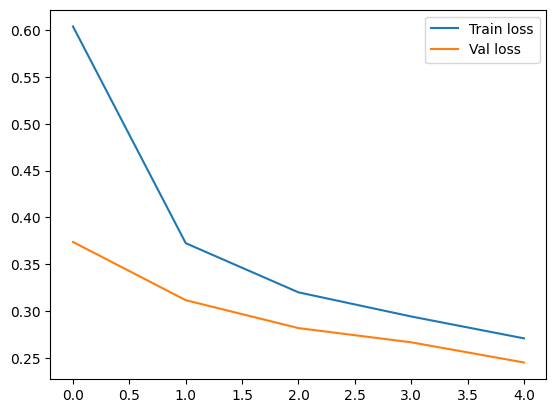

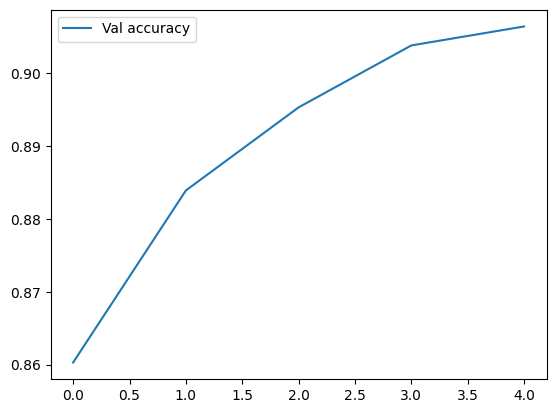

In [2]:
# Setup
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

torch.manual_seed(42)

# ---------- Data ----------
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
train_data, val_data = random_split(dataset, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=256)

# ---------- Model with Dropout ----------
class CleanCNNDrop(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # dropout regularization
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# ---------- Training Utilities ----------
def train_eval(model, epochs=5, lr=1e-3, weight_decay=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses, val_accs = [], [], []
    best_acc = 0
    patience, patience_counter = 3, 0  # early stopping

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss, correct, total = 0,0,0
        with torch.no_grad():
            for X,y in val_loader:
                X,y = X.to(device), y.to(device)
                out = model(X)
                val_loss += criterion(out,y).item()
                preds = out.argmax(dim=1)
                correct += (preds==y).sum().item()
                total += y.size(0)
        val_losses.append(val_loss/len(val_loader))
        acc = correct/total
        val_accs.append(acc)

        print(f"Epoch {epoch+1}: train {train_losses[-1]:.3f} | val {val_losses[-1]:.3f} | acc {acc:.3f}")

        # Early stopping
        if acc > best_acc:
            best_acc, patience_counter = acc, 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, val_accs

# ---------- Run ----------
model = CleanCNNDrop()
train_losses, val_losses, val_accs = train_eval(model, epochs=5, weight_decay=1e-4)

# ---------- Plot ----------
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend(); plt.show()

plt.plot(val_accs, label="Val accuracy")
plt.legend(); plt.show()


1) Core (10–15 min)

Task: Train once with dropout=0 and once with dropout=0.5. Compare curves.

Epoch 1: train 0.672 | val 0.405 | acc 0.848
Epoch 2: train 0.426 | val 0.331 | acc 0.877
Epoch 3: train 0.371 | val 0.332 | acc 0.874
Epoch 4: train 0.341 | val 0.281 | acc 0.894
Epoch 5: train 0.320 | val 0.272 | acc 0.897
Epoch 1: train 0.538 | val 0.371 | acc 0.866
Epoch 2: train 0.340 | val 0.326 | acc 0.883
Epoch 3: train 0.299 | val 0.298 | acc 0.891
Epoch 4: train 0.268 | val 0.293 | acc 0.894
Epoch 5: train 0.245 | val 0.253 | acc 0.905


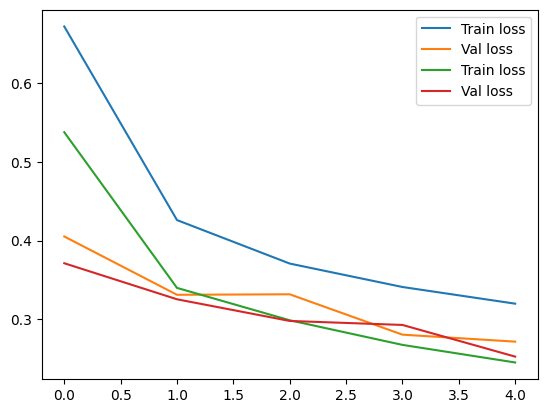

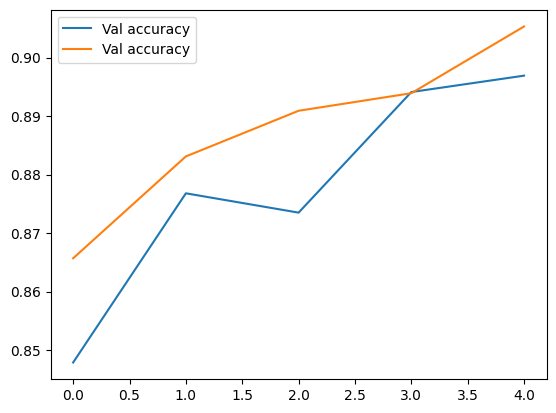

In [3]:
class CleanCNN_NoDrop(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))
    
class CleanCNNDrop_05(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # dropout regularization
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))
    

# ---------- Run ----------
model_05 = CleanCNNDrop_05()
train_losses_05, val_losses_05, val_accs_05 = train_eval(model_05, epochs=5, weight_decay=1e-4)

model_NoDrop = CleanCNN_NoDrop()
train_losses_NoDrop, val_losses_NoDrop, val_accs_NoDrop = train_eval(model_NoDrop, epochs=5, weight_decay=1e-4)

# ---------- Plot ----------
plt.plot(train_losses_05, label="Train loss")
plt.plot(val_losses_05, label="Val loss")
plt.plot(train_losses_NoDrop, label="Train loss")
plt.plot(val_losses_NoDrop, label="Val loss")
plt.legend(); plt.show()

plt.plot(val_accs_05, label="Val accuracy")
plt.plot(val_accs_NoDrop, label="Val accuracy")
plt.legend(); plt.show()

No dropout gets slightly better accuracy. The number of epochs might be too small  or normalisation might need to be in place in order to see more reliable results.

2) Practice (10–15 min)

Task: Add weight decay (1e-4) and compare validation accuracy.

Epoch 1: train 0.597 | val 0.375 | acc 0.862
Epoch 2: train 0.369 | val 0.319 | acc 0.880
Epoch 3: train 0.318 | val 0.293 | acc 0.892
Epoch 4: train 0.288 | val 0.274 | acc 0.900
Epoch 5: train 0.271 | val 0.252 | acc 0.906


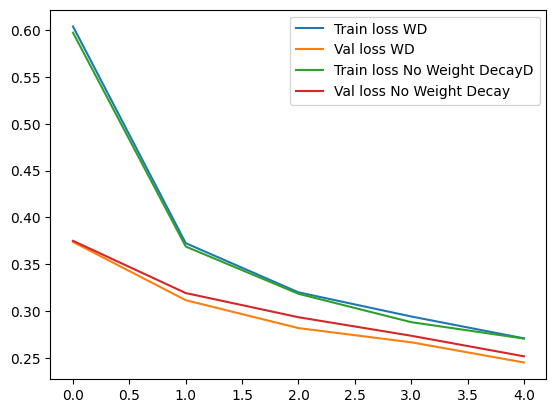

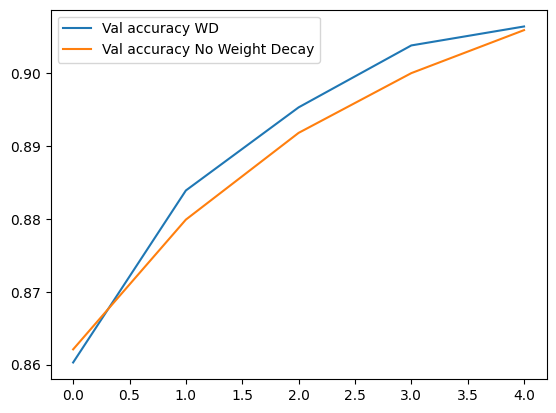

In [4]:
#As the example model already has weight decay ill compare it to one with no weight decay

model = CleanCNNDrop()
train_losses_no_wd, val_losses_no_wd, val_accs_no_wd = train_eval(model, epochs=5, weight_decay=0)

plt.plot(train_losses, label="Train loss WD")
plt.plot(val_losses, label="Val loss WD")
plt.plot(train_losses_no_wd, label="Train loss No Weight DecayD")
plt.plot(val_losses_no_wd, label="Val loss No Weight Decay")
plt.legend(); plt.show()

plt.plot(val_accs, label="Val accuracy WD")
plt.plot(val_accs_no_wd, label="Val accuracy No Weight Decay")
plt.legend(); plt.show()


Weight decay slightly outperforms no weight decay.

3) Stretch (optional, 10–15 min)

Task: Modify patience in early stopping (from 3 to 5) and see how many epochs are trained.

This one takes too much time. Skip for now.

Mini-Challenge (≤40 min)

Task:

Train 3 versions:

No regularization.

Dropout=0.3.

Dropout=0.3 + weight decay=1e-4.

Plot all validation accuracy curves on the same chart.

Write 3–4 lines: Which combo worked best and why?

Acceptance Criteria:

1 plot with 3 accuracy curves.

Note highlights overfitting reduction.

Epoch 1: train 0.525 | val 0.401 | acc 0.856
Epoch 2: train 0.328 | val 0.295 | acc 0.890
Epoch 3: train 0.279 | val 0.306 | acc 0.883
Epoch 4: train 0.250 | val 0.254 | acc 0.910
Epoch 5: train 0.226 | val 0.243 | acc 0.912


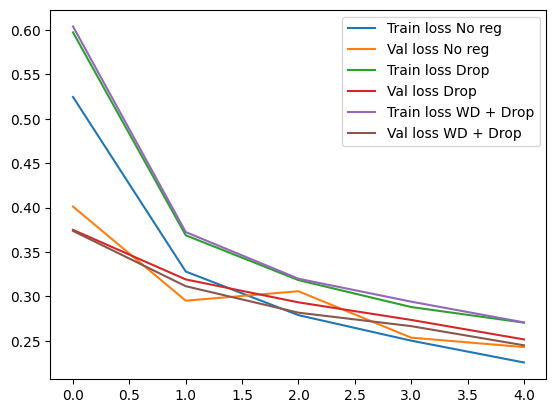

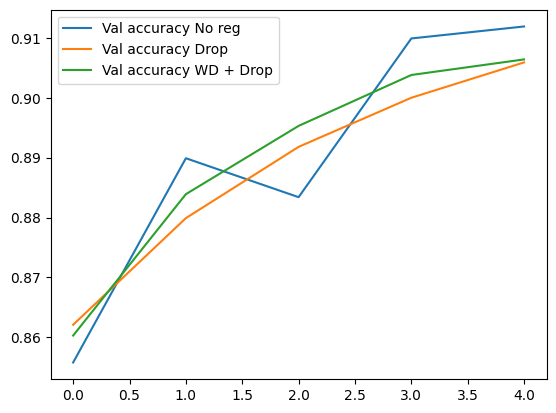

In [5]:
model_NoDrop = CleanCNN_NoDrop()
train_losses_NoReg, val_losses_NoReg, val_accs_NoReg = train_eval(model_NoDrop, epochs=5, weight_decay=0)

plt.plot(train_losses_NoReg, label="Train loss No reg")
plt.plot(val_losses_NoReg, label="Val loss No reg")
plt.plot(train_losses_no_wd, label="Train loss Drop")
plt.plot(val_losses_no_wd, label="Val loss Drop")
plt.plot(train_losses, label="Train loss WD + Drop")
plt.plot(val_losses, label="Val loss WD + Drop")
plt.legend(); plt.show()

plt.plot(val_accs_NoReg, label="Val accuracy No reg")
plt.plot(val_accs_no_wd, label="Val accuracy Drop")
plt.plot(val_accs, label="Val accuracy WD + Drop")
plt.legend(); plt.show()

Despite no regulirazation being the most accurate we can see how it is also the least stable. If training would've been more epochs the unstability of no reg would've shown more leading to a worse accuracy.

Notes / Key Takeaways

Regularization fights overfitting.

Dropout prevents co-adaptation of neurons.

Weight decay penalizes large weights.

Early stopping prevents wasted training when val acc plateaus.

Balance is key: too much regularization → underfit.

Reflection

Why does dropout sometimes slow training but improve generalization?

How does weight decay differ conceptually from dropout?

🔹 Why does dropout sometimes slow training but improve generalization?

During training, dropout randomly zeros activations → the model can’t rely on specific neurons and must learn redundant, robust features.

This makes optimization slower (since gradients are noisier and effective capacity is reduced).

But at evaluation, dropout is off and the full network is used, so the learned features generalize better and resist overfitting.

🔹 How does weight decay differ conceptually from dropout?

Weight decay (L2 regularization): directly penalizes large weights in the loss function, encouraging the model to keep parameters small and smooth. It’s a constraint on parameter magnitude.

Dropout: randomly removes activations during training, forcing the network to spread information across many neurons. It’s a stochastic noise injection at the feature level.